In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import PIL
import pathlib
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-05-21 17:33:34.575902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 17:33:35.301979: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 17:33:35.568222: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-21 17:33:37.723766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
tf.executing_eagerly()

True

In [3]:
tf.config.list_physical_devices('GPU')

2023-05-21 17:33:43.800618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 17:33:43.942579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 17:33:43.943923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_data_path = r'/mnt/c/Users/maxxt/Downloads/Projects/Poker Reader/archive/train'

train_data_dir = pathlib.Path(train_data_path).with_suffix('')
test_data_dir = pathlib.Path('/mnt/c/Users/maxxt/Downloads/Projects/Poker\ Reader/archive/test')

train_data_df = pd.read_csv('/mnt/c/Users/maxxt/Downloads/Projects/Poker Reader/archive/Training_set.csv')

In [5]:
batch_size = 8
image_height = 180
image_width = 180

validation_percentage = .125/3
image_size = len(train_data_df['filename'])

class_names = list(set(train_data_df['label']))

In [6]:
train_data_df['label'] = train_data_df['label'].map(lambda x: class_names.index(x))

In [7]:
keys_tensor = tf.constant(train_data_df.filename.map(lambda x: x.encode('ascii')))
vals_tensor = train_data_df.label
image_dic = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), default_value=-1)

2023-05-21 17:33:44.082005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 17:33:44.089567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 17:33:44.090829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-21 17:33:44.091861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bu

In [8]:
image_size

4776

In [9]:
file_ds = tf.data.Dataset.list_files(train_data_path+'/*', shuffle=False)
file_ds = file_ds.shuffle(image_size, reshuffle_each_iteration=False)

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

def read_image(filepath):
    img = tf.io.read_file(filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    return normalization_layer(tf.image.resize(img, [image_width, image_height])), get_label(filepath)

In [11]:
def get_label(filepath):
    parts = tf.strings.split(filepath, os.path.sep)
    
    return image_dic.lookup(parts[-1])

In [12]:
full_ds = file_ds.map(read_image)

In [13]:
full_ds

<MapDataset element_spec=(TensorSpec(shape=(180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
train_ds = full_ds.skip(int(image_size * validation_percentage))
val_ds = full_ds.take(int(image_size * validation_percentage))

In [15]:
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [16]:
for image, label in train_ds.take(1):
    print(image, label)
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

tf.Tensor(
[[[[0.9428667  0.9428667  0.9428667 ]
   [0.9438548  0.9438548  0.9438548 ]
   [0.9643331  0.9643331  0.9643331 ]
   ...
   [0.95525044 0.95525044 0.9630936 ]
   [0.9502412  0.9502412  0.95808434]
   [0.96140957 0.96140957 0.9692527 ]]

  [[0.94225574 0.94225574 0.9393799 ]
   [0.9495599  0.9495599  0.94773865]
   [0.94124913 0.94124913 0.94124913]
   ...
   [0.9512418  0.9512418  0.9590849 ]
   [0.94405234 0.94405234 0.9518955 ]
   [0.95093703 0.95093703 0.95878017]]

  [[0.9448052  0.9448052  0.93696207]
   [0.9471751  0.9471751  0.94220775]
   [0.94851136 0.94851136 0.94851136]
   ...
   [0.9547446  0.9547446  0.9625877 ]
   [0.95053744 0.95053744 0.9583806 ]
   [0.95619714 0.95619714 0.9640403 ]]

  ...

  [[0.94948703 0.94948703 0.95733017]
   [0.9470298  0.9470298  0.954873  ]
   [0.9456306  0.9456306  0.95347375]
   ...
   [0.9440331  0.9440331  0.9440331 ]
   [0.9526365  0.9526365  0.9526365 ]
   [0.95303303 0.95303303 0.95303303]]

  [[0.95638347 0.95638347 0.964226

In [17]:
model = keras.models.load_weights('/home/maxxt/Poker-Reader/model_cur.h5')

In [18]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_27 (Bat  (None, 180, 180, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_18 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_28 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                      

In [19]:
"""
num_classes = 53

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(180,180,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
"""

"\nnum_classes = 53\n\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Input(shape=(180,180,3)),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.Conv2D(32, (3,3)),\n    tf.keras.layers.Activation('relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(64, (3,3)),\n    tf.keras.layers.Activation('relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(2,2),\n    tf.keras.layers.Conv2D(64, (3,3)),\n    tf.keras.layers.Activation('relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(128, (3,3)),\n    tf.keras.layers.Activation('relu'),\n    tf.keras.layers.BatchNormalization(),\n    tf.keras.layers.MaxPooling2D(2,2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(num_classes, activation='softmax')\n])\n"

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
ck_path = "training/cp.ckpt"
ck_dir = os.path.dirname(ck_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=ck_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [21]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    batch_size=8,
    callbacks=[cp_callback]
)

Epoch 1/3


2023-05-21 17:34:18.221104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8901
2023-05-21 17:34:23.413366: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-21 17:34:28.507318: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


573/573 [==============================] - 281s 445ms/step - loss: 3.9088 - accuracy: 0.3133 - val_loss: 1.9303 - val_accuracy: 0.5276
Epoch 2/3
573/573 [==============================] - 259s 438ms/step - loss: 1.5412 - accuracy: 0.6030 - val_loss: 1.5770 - val_accuracy: 0.5930
Epoch 3/3
573/573 [==============================] - 248s 418ms/step - loss: 0.8809 - accuracy: 0.7505 - val_loss: 1.4666 - val_accuracy: 0.6583


In [22]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_27 (Bat  (None, 180, 180, 3)      12        
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 activation_18 (Activation)  (None, 178, 178, 32)      0         
                                                                 
 batch_normalization_28 (Bat  (None, 178, 178, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                      

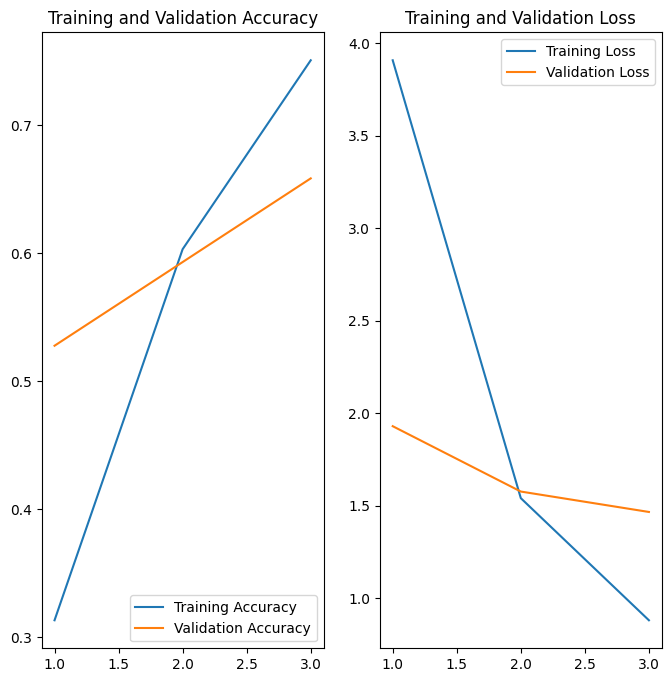

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1,4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
model.save_weights('model_05_23.h5')

In [25]:
model.evaluate(val_ds, verbose = 2)

25/25 - 10s - loss: 1.4666 - accuracy: 0.6583 - 10s/epoch - 384ms/step


[1.466593861579895, 0.6582914590835571]